In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap

# Descriptive approach for the data

There is 3 differents files

In [2]:
PATH = '/Users/xavierpivan/HubOcean/data/Hackathon/'
aggregated_path = PATH+'aggregated-values.csv'
probability_of_occurrence_path = PATH+'probability-of-occurrence.csv'
time_serie_path = PATH+'time-series.csv'

In [3]:
df_agg = pd.read_csv(aggregated_path, header=14)
df_prob = pd.read_csv(probability_of_occurrence_path, header=15)
df_series = pd.read_csv(time_serie_path, header=17, index_col=0)

In [4]:
#Let's have a look at the data

In [5]:
def print_box(df, key_lon='xlong', key_lat='xlat'):
    print('Min lon {} and Max lon {}'.format(df[key_lon].min(),
    df[key_lon].max()))
    print('Min lat {} and Max lat {}'.format(df[key_lat].min(),
    df[key_lon].max()))

print_box(df_prob)
print_box(df_agg)

Min lon 4.755432 and Max lon 5.136749
Min lat 53.163967 and Max lat 5.136749
Min lon 33.341217 and Max lon 34.368622
Min lat 26.226891 and Max lat 34.368622


In [6]:
df_prob.describe()

,xlat,xlong,dx,count,wsp_avg,tc_avg,rho_avg,hgt_avg,rh_avg,shear_avg,wsp_perc_interval,tc_perc_interval,rho_perc_interval,hgt_perc_interval,rh_perc_interval,icing_perc_interval,shear_perc_interval,comb_perc_interval
count,56.000000,56.000000,56.0,56.0,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.0,56.0,56.0,56.0,56.0,56.000000
mean,53.252919,4.945455,3000.0,121337.0,8.066005,10.374472,1.238049,0.323571,81.304184,0.103116,21.865474,2.461150,100.0,100.0,100.0,100.0,100.0,0.871260
std,0.051607,0.116212,0.0,0.0,0.257212,0.036367,0.000180,0.512581,0.490367,0.011312,1.386794,0.357194,0.0,0.0,0.0,0.0,0.0,0.199962
min,53.163967,4.755432,3000.0,121337.0,7.305903,10.319203,1.237581,0.000000,80.271351,0.085416,19.966704,1.720827,100.0,100.0,100.0,100.0,100.0,0.511798
25%,53.209962,4.844627,3000.0,121337.0,7.968404,10.345220,1.237989,0.000000,81.001542,0.095891,20.948474,2.203986,100.0,100.0,100.0,100.0,100.0,0.712272
50%,53.253298,4.946198,3000.0,121337.0,8.062867,10.368688,1.238071,0.025000,81.306514,0.102280,21.677230,2.555692,100.0,100.0,100.0,100.0,100.0,0.906154
75%,53.296834,5.047608,3000.0,121337.0,8.244363,10.400291,1.238172,0.482500,81.671062,0.107798,22.354270,2.649851,100.0,100.0,100.0,100.0,100.0,0.978679
max,53.339054,5.136749,3000.0,121337.0,8.477725,10.462527,1.238360,2.420000,82.129922,0.135901,26.030807,3.193585,100.0,100.0,100.0,100.0,100.0,1.420836


In [7]:
df_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   xlat                 56 non-null     float64
 1   xlong                56 non-null     float64
 2   dx                   56 non-null     int64  
 3   count                56 non-null     int64  
 4   wsp_avg              56 non-null     float64
 5   tc_avg               56 non-null     float64
 6   rho_avg              56 non-null     float64
 7   hgt_avg              56 non-null     float64
 8   rh_avg               56 non-null     float64
 9   shear_avg            56 non-null     float64
 10  wsp_perc_interval    56 non-null     float64
 11  tc_perc_interval     56 non-null     float64
 12  rho_perc_interval    56 non-null     float64
 13  hgt_perc_interval    56 non-null     float64
 14  rh_perc_interval     56 non-null     float64
 15  icing_perc_interval  56 non-null     float

In [8]:
df_agg.describe()

,xlat,xlong,swdown_avg,t2_avg,tkepbl_avg_30.0,wsp_avg_30.0,t2_max,sst_min
count,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000
mean,26.639216,33.854193,269.031922,297.061525,0.409742,7.343711,314.511351,95.524411
std,0.238528,0.296707,5.009776,1.295160,0.102935,1.220176,4.528890,137.645856
min,26.226891,33.341217,261.335840,290.007100,0.200287,4.242628,306.290000,0.000000
25%,26.432471,33.596672,263.258303,296.067424,0.306013,6.384357,309.182500,0.000000
50%,26.639217,33.854645,269.889306,297.459350,0.422686,7.484414,316.950000,0.000000
75%,26.845183,34.110374,273.553271,298.168879,0.476131,8.461402,318.072500,294.130000
max,27.053921,34.368622,278.561307,299.651181,0.708228,10.216145,320.190000,294.350000


In [9]:
df_agg

,xlat,xlong,swdown_avg,t2_avg,tkepbl_avg_30.0,wsp_avg_30.0,t2_max,sst_min
0,26.261333,34.102631,268.890527,297.289235,0.447353,7.351106,318.36,0.00
1,26.232861,33.521881,274.004093,295.996822,0.438939,6.385474,318.03,0.00
2,26.701832,33.757568,271.128651,296.932657,0.540973,7.691028,317.74,0.00
3,26.424404,33.513000,274.407823,295.527186,0.415028,5.856394,317.31,0.00
4,26.923096,33.416718,277.318947,295.159935,0.588032,8.906625,315.55,0.00
...,...,...,...,...,...,...,...,...
1031,26.407349,33.997833,268.919347,296.987645,0.438265,7.147556,316.44,0.00
1032,26.811600,34.044617,263.120937,298.105878,0.283086,8.471670,308.60,294.22
1033,26.654438,34.270203,262.804425,298.267652,0.313507,8.794749,306.69,294.21
1034,26.397038,33.814117,270.544467,297.241576,0.463233,7.116579,318.45,0.00


In [10]:
#Let's consider that if sst_min is 0, it is a marker that the data point is in land
print('Percentage of aggregated data on land is {}'.format(len(df_agg[df_agg['sst_min']==0])/len(df_agg)))

Percentage of aggregated data on land is 0.6747104247104247


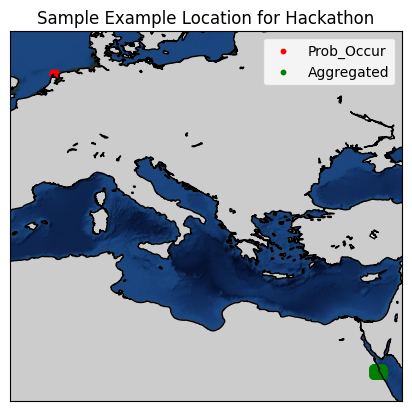

In [11]:
m = Basemap(width=12000000, height=9000000,
                resolution='i', 
                llcrnrlon=1, urcrnrlon=36,
                llcrnrlat=24, urcrnrlat=57
               )
# draw coastlines.
m.bluemarble()
m.drawcoastlines()
m.fillcontinents()
x, y = m(df_prob['xlong'], df_prob['xlat'])
x2, y2 = m(df_agg['xlong'], df_agg['xlat'])
m.scatter(x, y, 10, marker='o', color='r', label='Prob_Occur')
m.scatter(x2, y2, 10, marker='o', color='g', label='Aggregated')
plt.legend()
plt.title('Sample Example Location for Hackathon')
plt.savefig('Location_agg_and_prob_data.jpeg', dpi=399)

In [12]:
[*df_series]


['hfx',
 'hgt',
 'psfc',
 'swdown',
 't2',
 'ust',
 'rho_20.0',
 'tk_20.0',
 'tkepbl_20.0',
 'wsp_20.0',
 'rho_40.0',
 'tk_40.0',
 'tkepbl_40.0',
 'wsp_40.0',
 'rho_60.0',
 'tk_60.0',
 'tkepbl_60.0',
 'wsp_60.0',
 'rho_80.0',
 'tk_80.0',
 'tkepbl_80.0',
 'wsp_80.0',
 'rho_100.0',
 'tk_100.0',
 'tkepbl_100.0',
 'wsp_100.0',
 'rho_125.0',
 'tk_125.0',
 'tkepbl_125.0',
 'wsp_125.0',
 'rho_150.0',
 'tk_150.0',
 'tkepbl_150.0',
 'wsp_150.0',
 'rho_175.0',
 'tk_175.0',
 'tkepbl_175.0',
 'wsp_175.0',
 'rho_200.0',
 'tk_200.0',
 'tkepbl_200.0',
 'wsp_200.0',
 'rho_233.0',
 'tk_233.0',
 'tkepbl_233.0',
 'wsp_233.0',
 'rho_266.0',
 'tk_266.0',
 'tkepbl_266.0',
 'wsp_266.0',
 'rho_300.0',
 'tk_300.0',
 'tkepbl_300.0',
 'wsp_300.0',
 'wdir_20.0',
 'wdir_40.0',
 'wdir_60.0',
 'wdir_80.0',
 'wdir_100.0',
 'wdir_125.0',
 'wdir_150.0',
 'wdir_175.0',
 'wdir_200.0',
 'wdir_233.0',
 'wdir_266.0',
 'wdir_300.0']

In [13]:
#Get list of variables we have
df_series.columns

Index(['hfx', 'hgt', 'psfc', 'swdown', 't2', 'ust', 'rho_20.0', 'tk_20.0',
       'tkepbl_20.0', 'wsp_20.0', 'rho_40.0', 'tk_40.0', 'tkepbl_40.0',
       'wsp_40.0', 'rho_60.0', 'tk_60.0', 'tkepbl_60.0', 'wsp_60.0',
       'rho_80.0', 'tk_80.0', 'tkepbl_80.0', 'wsp_80.0', 'rho_100.0',
       'tk_100.0', 'tkepbl_100.0', 'wsp_100.0', 'rho_125.0', 'tk_125.0',
       'tkepbl_125.0', 'wsp_125.0', 'rho_150.0', 'tk_150.0', 'tkepbl_150.0',
       'wsp_150.0', 'rho_175.0', 'tk_175.0', 'tkepbl_175.0', 'wsp_175.0',
       'rho_200.0', 'tk_200.0', 'tkepbl_200.0', 'wsp_200.0', 'rho_233.0',
       'tk_233.0', 'tkepbl_233.0', 'wsp_233.0', 'rho_266.0', 'tk_266.0',
       'tkepbl_266.0', 'wsp_266.0', 'rho_300.0', 'tk_300.0', 'tkepbl_300.0',
       'wsp_300.0', 'wdir_20.0', 'wdir_40.0', 'wdir_60.0', 'wdir_80.0',
       'wdir_100.0', 'wdir_125.0', 'wdir_150.0', 'wdir_175.0', 'wdir_200.0',
       'wdir_233.0', 'wdir_266.0', 'wdir_300.0'],
      dtype='object')

# Suggestions

- Give data sample at same location, if possible in land
- Create a section on the data description docx with metadata such "wdir_* represents the wind direction in [m/s] at level *" or will there be description included in the API ?
- A netcdf/zarr/grib data format file would be easier to handle. It would allow to extract variables at specific height with easy indexing.
- These formats would allow to include a self description of variable metadata within a notebook


# Play a bit with data

In [15]:
var1 = 'wsp'
var2 = 'wdir'
var3 = 'rho'
df, df2, df3 = (pd.DataFrame(index=df_series.index) for _ in range(3))
altitude = []

for col in df_series:
    if var1 in col:
        altitude.append(col.replace(var1+'_', ""))
        df[col] = df_series[col]
    elif var2 in col:
        df2[col] = df_series[col]
    elif var3 in col:
        df3[col] = df_series[col]
        
height = np.array(altitude, dtype = float)

Text(0.5, 1.0, 'Temporal evolution of wind speed in a vertical section')

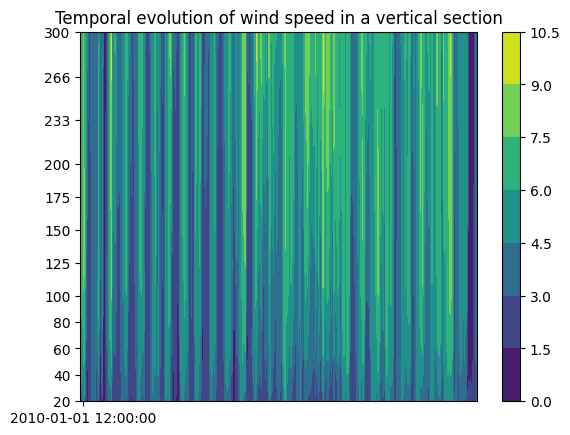

In [25]:
x_time = df_series.index
y = height

#Get xticks in right format
xticks = x[::60]

fig, ax = plt.subplots() 
plt.contourf(x_time,y,df.to_numpy().T)
ax.set_xticks(xticks)
ax.set_yticks(height)
plt.colorbar()
plt.title("Temporal evolution of wind speed in a vertical section")

In [26]:
wsp, wdir, rho = df.to_numpy(), df2.to_numpy(), df3.to_numpy()
np.shape(wsp)

(648, 12)

In [27]:
ds = xr.Dataset(
    {
        "wsp": (["time", "altitude"], wsp,
               {'units': 'Meter per Second', 'long_name': 'Wind Speed'}),
        "wdir": (["time", "altitude"], wdir,
                {'units': 'Degrees', 'long_name': 'Wind Direction'}),
        "rho": (["time", "altitude"], rho,
               {'units': 'kg/m3', 'long_name': 'Density'})
    },
    coords={
        "time": pd.date_range(x_time[0], periods=len(x_time), freq='H'),
        "altitude": height
    }
)

ds

<xarray.Dataset>
Dimensions:   (time: 648, altitude: 12)
Coordinates:
  * time      (time) datetime64[ns] 2010-01-01T07:00:00 ... 2010-01-28T06:00:00
  * altitude  (altitude) float64 20.0 40.0 60.0 80.0 ... 200.0 233.0 266.0 300.0
Data variables:
    wsp       (time, altitude) float64 3.881 4.181 4.43 ... 4.054 4.054 4.045
    wdir      (time, altitude) float64 32.98 32.24 31.66 ... 35.25 35.12 34.99
    rho       (time, altitude) float64 1.133 1.132 1.13 ... 1.109 1.106 1.103

In [28]:
#Example of extraction of all variables across the time
ds_sel = ds.sel(altitude=100.0)
ds_sel

<xarray.Dataset>
Dimensions:   (time: 648)
Coordinates:
  * time      (time) datetime64[ns] 2010-01-01T07:00:00 ... 2010-01-28T06:00:00
    altitude  float64 100.0
Data variables:
    wsp       (time) float64 4.653 6.213 6.005 6.204 ... 2.454 2.96 3.221 3.947
    wdir      (time) float64 30.92 28.78 20.25 14.98 ... 45.91 46.77 44.43 36.2
    rho       (time) float64 1.127 1.128 1.133 1.134 ... 1.132 1.128 1.124 1.121